In [20]:
import pandas as pd
df = pd.read_csv("./news.csv")
df.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [21]:
# Set value of label to 1 if FAKE, else to 0 for REAL
df['label'] = (df['label'] == 'FAKE').astype('int')
# Concatenate title and text into column alltext
df['alltext'] = df['title'] + ". " + df['text']
# Transform the dataset to contain only the label and all text columns
df = df.reindex(columns=['alltext', 'label'])
df.head(5)  # Show first 5 rows in dataset

,alltext,label
0,You Can Smell Hillary’s Fear. Daniel Greenfiel...,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy. U...,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matte...,0


In [22]:
# Remove texts that are less than 50 characters long
df.drop(df[df.alltext.str.len() < 50].index, inplace=True)
df = df.reset_index(drop=True)


def convert_to_lowercase(text):  # Convert all characters to lowercase
    return text.lower()


# Convert text to lowercase
df['alltext'] = df['alltext'].apply(convert_to_lowercase)
print("Samples:", len(df['alltext']))
print("Labels:", len(df['label']), "\n")
# Print the first 1000 characters of the first text as an example
print(df['alltext'].iloc[0][0:1000])
# Save processed dataset to csv file
df.to_csv('fakenews_processed.csv', index=False)

Samples: 6327
Labels: 6327 

you can smell hillary’s fear. daniel greenfield, a shillman journalism fellow at the freedom center, is a new york writer focusing on radical islam. 
in the final stretch of the election, hillary rodham clinton has gone to war with the fbi. 
the word “unprecedented” has been thrown around so often this election that it ought to be retired. but it’s still unprecedented for the nominee of a major political party to go war with the fbi. 
but that’s exactly what hillary and her people have done. coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillary’s opponent in this election. 
the fbi is under attack by everyone from obama to cnn. hillary’s people have circulated a letter attacking comey. there are currently more media hit pieces lambasting him than targeting trump. it wouldn’t be too surprising if the clintons or their allies were to start running attack ads against the fbi.

In [4]:
from sklearn.model_selection import train_test_split
# Split dataset into 30% for test and 70% for training
train, test = train_test_split(df, test_size=0.30, random_state=42)
X_train = train["alltext"].values  # Get the documents for training
Y_train = train["label"].values  # Get the labels for training
X_test = test["alltext"].values  # Get the documents for testing
Y_test = test["label"].values  # Get the labels for testing

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce the number of shown warnings

In [6]:
import tensorflow as tf
from keras.layers import TextVectorization
# The maximum number of words to be used (most frequent)
MAX_VOCABULARY_WORDS = 5000
# Number of words in each text. Sequence length to pad the outputs to.
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 10  # Size of the word embedding to be used
# Create a preprocessing layer which maps text features to integer sequences
vectorize_layer = TextVectorization(
    max_tokens=MAX_VOCABULARY_WORDS,  # Maximum size of the vocabulary for this layer
    output_mode='int',  # Represent each word in the vocabulary with an integer
    output_sequence_length=MAX_SEQUENCE_LENGTH)  # Pad the sequence length to size MAX_SEQUENCE_LENGTH
# Computes a vocabulary of string terms from tokens in a dataset.
vectorize_layer.adapt(X_train)
vocabulary = vectorize_layer.get_vocabulary()  # Get the vocabulary
print("Vocabulary size: " + str(len(vocabulary)) + " words")




Vocabulary size: 5000 words


In [7]:
from keras import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
model = Sequential(name="MyLSTM")
model.add(Input(shape=(1,), dtype=tf.string))

model.add(vectorize_layer)
model.add(Embedding(input_dim=MAX_VOCABULARY_WORDS,  # Size of the vocabulary
                    output_dim=EMBEDDING_DIM,  # Size of the word embedding
                    input_length=MAX_SEQUENCE_LENGTH))  # Length of input sequences
# Set return_sequences=True if you want additional LSTM layer
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Bidirectional(LSTM(16, go_backwards=True, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.summary()  # Print model summary

Model: "MyLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 200, 10)           50000     
                                                                 
 bidirectional (Bidirection  (None, 200, 32)           3456      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                            

In [8]:
from keras.optimizers import Adam
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
# Initialise Adam optimiser with a leanring rate of 0.01
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])  # Initialise model

In [9]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor="val_accuracy", patience=4,
                      restore_best_weights=True, mode="auto")
history = model.fit(X_train, Y_train,
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.1,  # Use 10% of training data for validation
                    callbacks=[early]
                    )

Epoch 1/50

63/63 [==============================] - 9s 78ms/step - loss: 0.3946 - accuracy: 0.8148 - val_loss: 0.2725 - val_accuracy: 0.8781
Epoch 2/50
63/63 [==============================] - 4s 64ms/step - loss: 0.1491 - accuracy: 0.9458 - val_loss: 0.2451 - val_accuracy: 0.8962
Epoch 3/50
63/63 [==============================] - 4s 62ms/step - loss: 0.0620 - accuracy: 0.9817 - val_loss: 0.3103 - val_accuracy: 0.9007
Epoch 4/50
63/63 [==============================] - 4s 64ms/step - loss: 0.0235 - accuracy: 0.9940 - val_loss: 0.3653 - val_accuracy: 0.8916
Epoch 5/50
63/63 [==============================] - 4s 62ms/step - loss: 0.0114 - accuracy: 0.9975 - val_loss: 0.4159 - val_accuracy: 0.8984
Epoch 6/50
63/63 [==============================] - 4s 63ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.4716 - val_accuracy: 0.9052
Epoch 7/50
63/63 [==============================] - 4s 63ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.4690 - val_accuracy: 0.8984
Epoch 8/50
6

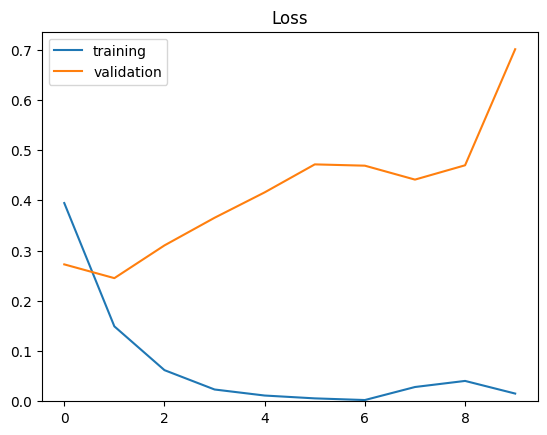

In [10]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(bottom=0.0)
plt.legend()
plt.show()

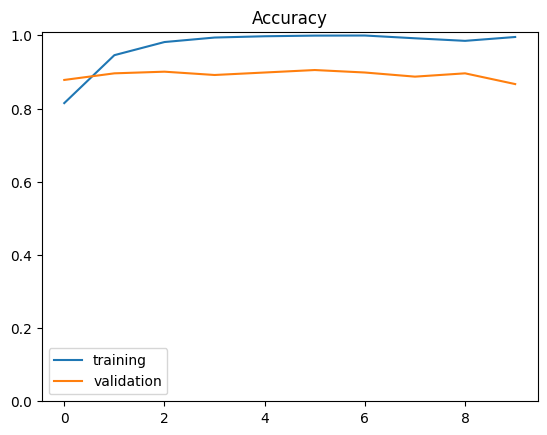

In [11]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylim(bottom=0.0, top=1.01)
plt.legend()
plt.show()

In [12]:
# Use model to predict the class of the documents in the test set
pred = model.predict(X_test)
# Print numpy array containing the predicted class labels
print("Predicted values:\n" + str(pred))
# Use the numpy.round() function to round the predictions to the nearest integer
pred = pred.round()
pred = pred.astype(int)  # Convert predicted values to integers
print("\nRounded values:\n" + str(pred))

60/60 [==============================] - 2s 18ms/step
Predicted values:
[[9.9999738e-01]
 [9.9820364e-01]
 [9.9591124e-01]
 ...
 [9.9999636e-01]
 [9.9376339e-01]
 [1.2815394e-05]]

Rounded values:
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]


In [13]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       949
           1       0.90      0.92      0.91       950

    accuracy                           0.91      1899
   macro avg       0.91      0.91      0.91      1899
weighted avg       0.91      0.91      0.91      1899



In [14]:
labels = {1: "FAKE", 0: "REAL"}
text = "the earth is not flat"
pred = model.predict([text])
pred = pred[0][0].round().astype(int)
print("\n" + text + ": " + labels[pred])

1/1 [==============================] - 0s 45ms/step

the earth is not flat: FAKE


In [15]:
import pickle
pickle.dump(model, open('mylstm.pkl', 'wb'))

In [16]:
loaded_model = pickle.load(open('mylstm.pkl', 'rb'))
new_pred = loaded_model.predict(X_test)
# Print numpy array containing the predicted class labels
print("Predicted values:\n" + str(new_pred))
# Use the numpy.round() function to round teh predictions to the nearest integer
new_pred = new_pred.round()
new_pred = new_pred.astype(int) # Convert predicted values to integers
print("\nRounded values:\n" + str(new_pred))
print(classification_report(Y_test,new_pred))

60/60 [==============================] - 2s 18ms/step
Predicted values:
[[9.9999738e-01]
 [9.9820364e-01]
 [9.9591124e-01]
 ...
 [9.9999636e-01]
 [9.9376339e-01]
 [1.2815394e-05]]

Rounded values:
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       949
           1       0.90      0.92      0.91       950

    accuracy                           0.91      1899
   macro avg       0.91      0.91      0.91      1899
weighted avg       0.91      0.91      0.91      1899



# Exercise8.1

Create a non-bidirectional LSTM model with a single LSTM layer with 32 units. Train it by
keeping all hyperparameters and training settings the same as for the model above. Plot the loss
and accuracy and compare them with the model above.

In [17]:
model = Sequential(name="NonBidirectionalLSTM")
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(input_dim=MAX_VOCABULARY_WORDS,
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "NonBidirectionalLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 200, 10)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 32)                5504      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55537 (216.94 KB)
Trainable params: 55537 (216.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Exercise8.2
Pre-process the dataset again in order to remove punctuation and stop words. Retrain the LSTM model from 8.2.2 using the new pre-processed dataset and compare its performance with when punctuation and stopwords are not removed.

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Remove punctuation and stopwords from the text
def preprocess_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove punctuation
    punctuation = string.punctuation
    punctuation = ''.join([punctuation, '`', "'","‘"])

    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply the pre-processing to the 'alltext' column in the dataframe
df_new = df.copy()
df_new['alltext'] = df_new['alltext'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QianZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df

,alltext,label
0,you can smell hillary’s fear. daniel greenfiel...,1
1,watch the exact moment paul ryan committed pol...,1
2,kerry to go to paris in gesture of sympathy. u...,0
3,bernie supporters on twitter erupt in anger ag...,1
4,the battle of new york: why this primary matte...,0
...,...,...
6322,state department says it can't find emails fro...,0
6323,the ‘p’ in pbs should stand for ‘plutocratic’ ...,1
6324,anti-trump protesters are tools of the oligarc...,1
6325,"in ethiopia, obama seeks progress on peace, se...",0


# Exercise 8.3

Train the model from Exercise 8.1 using the dataset from exercise 8.2 and the same hyperparameters and settings. Compare the performance to the one achieved in Exercise 8.1.

In [28]:
# Split the preprocessed dataset into training and testing sets
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(df_new['alltext'].values, df_new['label'].values, test_size=0.30, random_state=42)

# Create a non-bidirectional LSTM model with a single LSTM layer with 32 units
model_new = Sequential(name="NonBidirectionalLSTM")
model_new.add(Input(shape=(1,), dtype=tf.string))
model_new.add(vectorize_layer)
model_new.add(Embedding(input_dim=MAX_VOCABULARY_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_new.add(LSTM(32))
model_new.add(Dense(1, activation='sigmoid'))
model_new.summary()

# Compile the model with the Adam optimizer and binary cross-entropy loss
opt = Adam(learning_rate=LEARNING_RATE)
model_new.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model using the preprocessed training dataset for the specified number of epochs and batch size
history_new = model_new.fit(X_train_new, Y_train_new, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[early])

# Evaluate the model on the preprocessed testing dataset
loss_new, accuracy_new = model_new.evaluate(X_test_new, Y_test_new)
print("Test Loss:", loss_new)
print("Test Accuracy:", accuracy_new)

# Compare the performance of this model with the one achieved in Exercise 8.1
print("Performance comparison:")
print("Original Model - Test Loss:", history.history['val_loss'][-1])
print("Original Model - Test Accuracy:", history.history['val_accuracy'][-1])
print("New Model - Test Loss:", loss_new)
print("New Model - Test Accuracy:", accuracy_new)


Model: "NonBidirectionalLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 200, 10)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 32)                5504      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 55537 (216.94 KB)
Trainable params: 55537 (216.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
63/63 [==============================] - 4s 38ms/step - loss: 0